In [89]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '../segnext')
import torch

from isegm.utils.vis import draw_with_blend_and_clicks
from isegm.inference.utils import get_iou
from isegm.inference.clicker import Clicker
from isegm.inference import utils
from isegm.data.datasets import DavisDataset
from isegm.inference.predictor import BasePredictor

dataset_path = '../data/DAVIS345/'
dataset = DavisDataset(dataset_path)

device = torch.device('cpu')
model_path = '../weights/vitb_sa2_cocolvis_hq44k_epoch_0.pth'
model = utils.load_is_model(model_path, device)
predictor = BasePredictor(model)

sample_idx = 71
sample = dataset.get_sample(sample_idx)
image, gt_mask = sample.image, sample.gt_mask(0)

clicker = Clicker(gt_mask=gt_mask)
pred_mask = np.zeros_like(gt_mask)

pred_thr = 0.49
max_iou_thr = 0.95
max_clicks = 20
ious_list = []
with torch.no_grad():
    predictor.set_image(image)
    for click_indx in range(max_clicks):
        clicker.make_next_click(pred_mask)
        pred_probs = predictor.predict(clicker)
        pred_mask = pred_probs > pred_thr

        iou = get_iou(gt_mask, pred_mask)
        ious_list.append(iou)
        if iou >= max_iou_thr:
            break

ious_list_pred = [0.5505077498663816, 
                  0.8780602234922801, 
                  0.9188086841993457, 
                  0.9361775927852931, 
                  0.9430919183530748, 
                  0.9437601367641257, 
                  0.9483890872228833, 
                  0.9506340183646699]
diff = np.sum(np.abs(np.array(ious_list) - np.array(ious_list_pred)))
assert diff < 1e-6

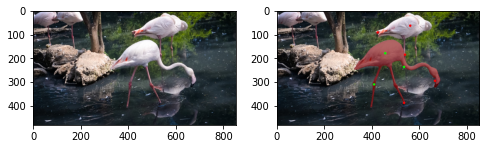

In [90]:
image_with_mask = draw_with_blend_and_clicks(
    image, pred_mask, clicks_list=clicker.clicks_list,radius=5)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(image_with_mask)
